## Exercise 1.1: Build a simple OOD detection pipeline

### Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from torch import Tensor
from tqdm import tqdm
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, roc_auc_score, average_precision_score

### Load Cifar10

In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 64

In [3]:
transform_train_10 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test_10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train_10)

train_set, val_set = torch.utils.data.random_split(cifar10, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=False)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test_10)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                          drop_last=False)


100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


In [4]:
cifar10_class_to_idx = cifar10.class_to_idx
cifar10_classes = list(cifar10_class_to_idx.keys())

print(cifar10_classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Load Cifar100 and pick a subset of classes

In [5]:
transform_test_100 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_test_100)

cifar100_class_to_idx = cifar100.class_to_idx
cifar100_classes = list(cifar100_class_to_idx.keys())

100%|██████████| 169M/169M [00:13<00:00, 13.0MB/s]


In [6]:
print(cifar100_classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [7]:
non_overlapping_classes = [name for name in cifar100_classes if name not in cifar10_classes]

In [8]:
print(non_overlapping_classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [9]:
seed = 1023
torch.manual_seed(seed)

random.shuffle(non_overlapping_classes)
print(non_overlapping_classes[:10])

['tiger', 'chimpanzee', 'elephant', 'sea', 'lobster', 'woman', 'baby', 'aquarium_fish', 'cockroach', 'caterpillar']


In [10]:
print(non_overlapping_classes)

['tiger', 'chimpanzee', 'elephant', 'sea', 'lobster', 'woman', 'baby', 'aquarium_fish', 'cockroach', 'caterpillar', 'pear', 'otter', 'television', 'flatfish', 'plain', 'seal', 'orchid', 'bridge', 'sweet_pepper', 'crab', 'mountain', 'road', 'bear', 'squirrel', 'tank', 'lizard', 'dinosaur', 'lawn_mower', 'motorcycle', 'house', 'dolphin', 'rose', 'lamp', 'oak_tree', 'bicycle', 'can', 'tractor', 'bed', 'snail', 'snake', 'bottle', 'willow_tree', 'wardrobe', 'chair', 'train', 'beaver', 'porcupine', 'forest', 'telephone', 'plate', 'shark', 'beetle', 'mushroom', 'lion', 'wolf', 'table', 'poppy', 'crocodile', 'kangaroo', 'possum', 'man', 'rabbit', 'palm_tree', 'sunflower', 'rocket', 'bee', 'pine_tree', 'raccoon', 'cup', 'skyscraper', 'trout', 'cloud', 'mouse', 'bowl', 'leopard', 'keyboard', 'ray', 'turtle', 'tulip', 'cattle', 'couch', 'camel', 'bus', 'castle', 'spider', 'hamster', 'worm', 'skunk', 'girl', 'fox', 'pickup_truck', 'whale', 'boy', 'butterfly', 'shrew', 'clock', 'streetcar', 'apple'

In [11]:
ood_class_names = non_overlapping_classes[:20]
ood_class_indices = {cifar100_class_to_idx[name] for name in ood_class_names}

In [12]:
print(ood_class_indices)

{1, 2, 12, 18, 21, 24, 26, 31, 32, 45, 54, 55, 57, 60, 71, 72, 83, 87, 88, 98}


In [13]:
ood_sample_indices = [
    i for i, (_, label) in enumerate(cifar100)
    if label in ood_class_indices
]

random.shuffle(ood_sample_indices)

ood_sample_indices = ood_sample_indices[:len(test_set)]

cifar100_ood_subset = Subset(cifar100, ood_sample_indices)

ood_loader = torch.utils.data.DataLoader(cifar100_ood_subset, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=False)

### Network

In [14]:
class LinearBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.fc = nn.Linear(width, width)

    def forward(self, x):
        return F.relu(self.fc(x))


class ResMLPBlock(nn.Module):
    def __init__(self, width):
        super().__init__()
        self.network = nn.Sequential(LinearBlock(width), LinearBlock(width))

    def forward(self, x):
        return self.network(x) + x


class BasicConvBlock(nn.Module):
    def __init__(self, inplanes: int, planes: int, stride: int = 1, residual: bool = True):
        super().__init__()
        self.residual = residual

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)


    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.residual:
            out += identity
        out = self.relu(out)
        return out


class Net(nn.Module):
    def __init__(self, mode='mlp', input_size=28*28, in_channels=1, width=64, base_channels=64,
                 depth=1, residual=False, output_size=10, return_features=False):
        super().__init__()
        self.mode = mode
        self.return_features = return_features

        if mode == 'mlp':
            blocks = [ResMLPBlock(width) if residual else LinearBlock(width) for _ in range(depth)]
            self.feature_extractor = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, width),
                nn.ReLU(),
                *blocks
            )
            self.classifier = nn.Linear(width, output_size)

        elif mode == 'cnn':
            blocks = [BasicConvBlock(base_channels, base_channels, residual=residual) for _ in range(depth)]
            self.feature_extractor = nn.Sequential(
                nn.Conv2d(in_channels, base_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(base_channels),
                nn.ReLU(inplace=True),
                *blocks,
                nn.AdaptiveAvgPool2d((1, 1)),
                nn.Flatten()
            )
            self.fc = nn.Linear(base_channels, base_channels)
            self.classifier = nn.Linear(base_channels, output_size)
        else:
            raise ValueError("Mode must be either 'mlp' or 'cnn'")

    def forward(self, x):
        features = self.feature_extractor(x)
        if self.return_features:
            return features
        return self.classifier(features)

    def get_features(self, x):
        return self.feature_extractor(x)


### Functions

In [15]:
def train_epoch(model, train_loader, optimizer, criterion, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (inputs, labels) in tqdm(train_loader, desc=f'Training epoch {epoch}', leave=True):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)

In [16]:
def train(model, epochs, optimizer, train_loader, criterion, device='cpu'):
  losses = []

  for epoch in range(epochs):

    loss = train_epoch(model, train_loader, optimizer, criterion, epoch, device=device)
    losses.append(loss)

  return losses

In [17]:
def get_scores(dataloader, model):
    model.eval()
    all_max_logits = []
    all_max_probs = []
    with torch.no_grad():

        for x, _ in dataloader:

            x = x.cuda()
            logits = model(x)
            max_logit, _ = torch.max(logits, dim=1)

            probs = F.softmax(logits, dim=1)
            max_probs, _ = torch.max(probs, dim=1)

            all_max_probs.extend(max_probs.cpu().numpy())
            all_max_logits.extend(max_logit.cpu().numpy())

    return all_max_logits, all_max_probs

In [18]:
def plot_histograms(id_logits, id_probs, ood_logits, ood_probs):
  plt.hist(id_logits, bins=60, alpha=0.7, label='ID (CIFAR-10)')
  plt.hist(ood_logits, bins=50, alpha=0.7, label='OOD (CIFAR-100)')
  plt.xlabel('Max Logits')
  plt.ylabel('Frequency')
  plt.title('Histogram for OOD Detection')
  plt.legend()
  plt.show()

  plt.hist(id_probs, bins=60, alpha=0.7, label='ID (CIFAR-10)')
  plt.hist(ood_probs, bins=50, alpha=0.7, label='OOD (CIFAR-100)')
  plt.xlabel('Max Softmax Probability')
  plt.ylabel('Frequency')
  plt.title('Histogram for OOD Detection')
  plt.legend()
  plt.show()

In [19]:
def plot_roc_pr_curves(labels, scores):

  roc_auc = roc_auc_score(labels, -scores)
  print(f"ROC AUC = {roc_auc:.4f}")

  RocCurveDisplay.from_predictions(labels, -scores)
  plt.title("ROC Curve for OOD Detection")
  plt.show()

  PrecisionRecallDisplay.from_predictions(labels, -scores)
  plt.title("PR Curve for OOD (label=1)")
  plt.show()

  PrecisionRecallDisplay.from_predictions(1 - labels, scores)
  plt.title("PR Curve for ID (label=1)")
  plt.show()

## Exercise 1.2: Measure your OOD detection performance

### Training

In [20]:
epochs = 100
lr = 0.001
seed = 1023
torch.manual_seed(seed)

depth=5

model_base = Net(mode='cnn', in_channels=3, base_channels=64, depth=depth, residual=True, output_size=10).to(device)

optimizer = torch.optim.Adam(params=model_base.parameters(), lr=lr)

losses = train(model_base, epochs, optimizer, train_loader, F.cross_entropy, device=device)

Training epoch 99: 100%|██████████| 625/625 [00:28<00:00, 21.91it/s]


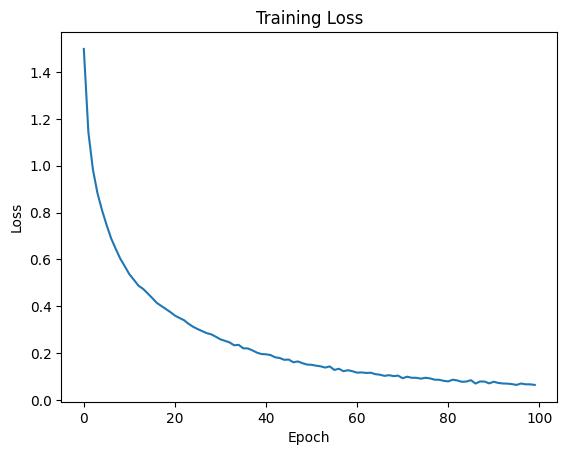

In [21]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Histogram scores

#### Logits and probabilities

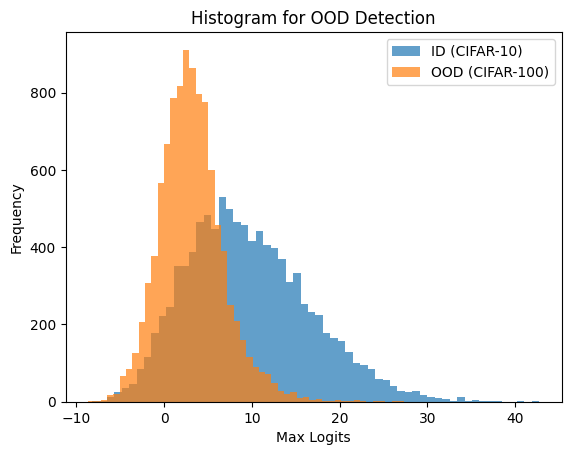

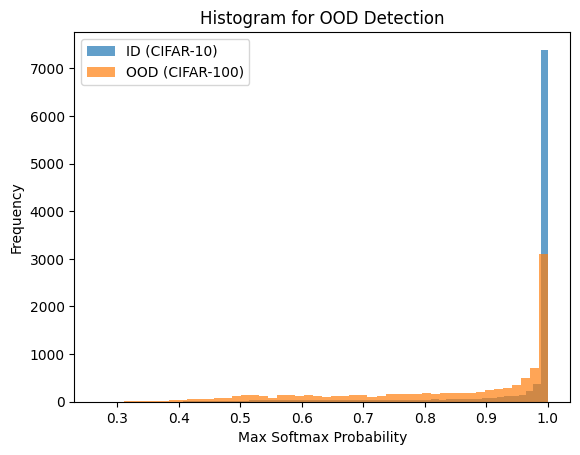

In [ ]:
id_logits, id_probs = get_scores(test_loader, model_base)
ood_logits, ood_probs = get_scores(ood_loader, model_base)

plot_histograms(id_logits, id_probs, ood_logits, ood_probs)

#### Autoencoder loss

##### Network

In [ ]:
class Decoder(nn.Module):
    def __init__(self, base_channels=64, img_shape=(1, 28, 28)):
        super().__init__()
        self.img_shape = img_shape
        self.decoder = nn.Sequential(
            nn.Linear(base_channels, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, img_shape[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)
        reconstruction = self.decoder(features)
        return reconstruction


##### Functions

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, epoch='Unknown', device='cpu'):

    model.train()
    losses = []

    for (inputs, _) in tqdm(train_loader, desc=f'Training epoch {epoch}', leave=True):
        inputs = inputs.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, inputs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return np.mean(losses)

In [ ]:
def train(model, epochs, optimizer, train_loader, criterion, device='cpu'):
  losses = []

  for epoch in range(epochs):

    loss = train_epoch(model, train_loader, optimizer, criterion, epoch, device=device)
    losses.append(loss)

  return losses

In [ ]:
def get_reconstruction_errors(loader, model):
    model.eval()
    errors = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            output = model(x)
            err = F.mse_loss(output, x, reduction='none')
            err = err.view(err.size(0), -1).mean(dim=1)
            errors.extend(err.cpu().numpy())
    return errors

##### Training

In [ ]:
epochs = 100
lr = 0.001
seed = 1023
torch.manual_seed(seed)

decoder = Decoder().to(device)
autoencoder = Autoencoder(model_base.feature_extractor, decoder).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.decoder.parameters(), lr=lr)

losses_ae = train(autoencoder, epochs, optimizer, train_loader, criterion, device=device)

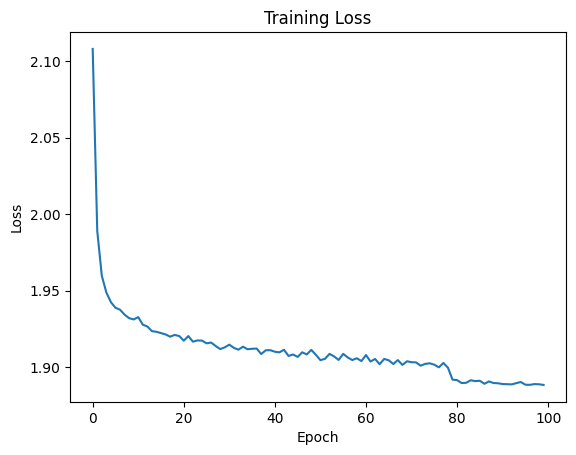

In [ ]:
plt.plot(losses_ae)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

##### Score

/tmp/ipython-input-233-2945909318.py:8: UserWarning: Using a target size (torch.Size([64, 3, 32, 32])) that is different to the input size (torch.Size([64, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  err = F.mse_loss(output, x, reduction='none')
/tmp/ipython-input-233-2945909318.py:8: UserWarning: Using a target size (torch.Size([64, 3, 32, 32])) that is different to the input size (torch.Size([64, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  err = F.mse_loss(output, x, reduction='none')
/tmp/ipython-input-233-2945909318.py:8: UserWarning: Using a target size (torch.Size([16, 3, 32, 32])) that is different to the input size (torch.Size([16, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  err = F.mse_loss(output, x, reduction='none')


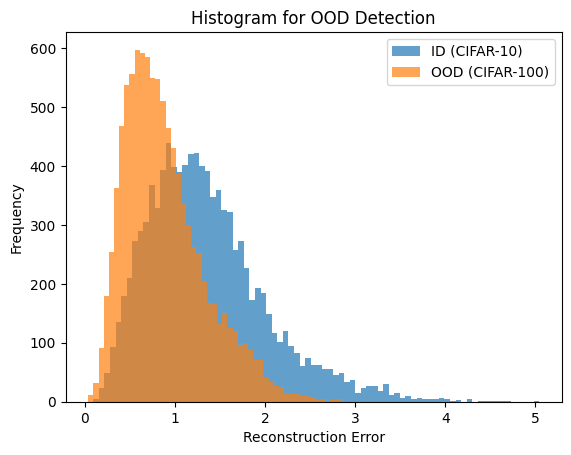

In [ ]:
id_errors = get_reconstruction_errors(test_loader, autoencoder)
ood_errors = get_reconstruction_errors(ood_loader, autoencoder)

plt.hist(id_errors, bins=80, alpha=0.7, label='ID (CIFAR-10)')
plt.hist(ood_errors, bins=50, alpha=0.7, label='OOD (CIFAR-100)')

plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram for OOD Detection')
plt.legend()
plt.show()

### ROC and Precision-Recall curves

ROC AUC = 0.8090


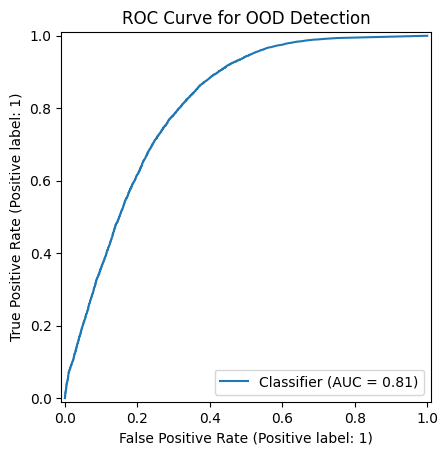

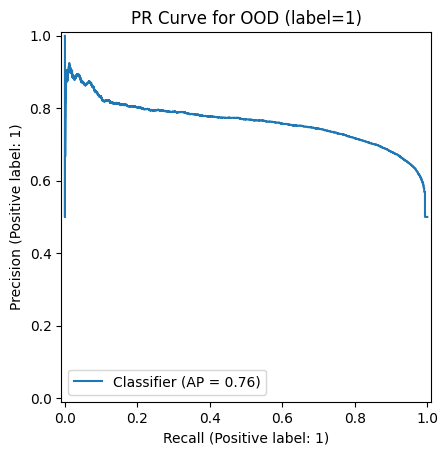

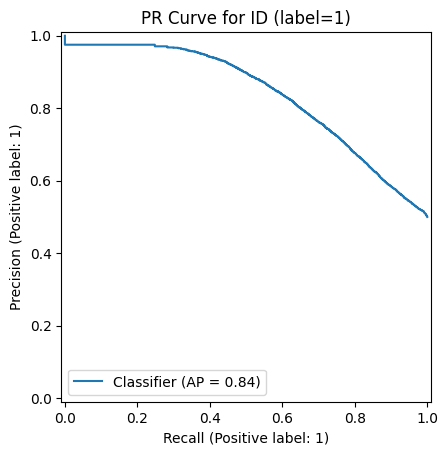

In [31]:
id_logits, id_probs = get_scores(test_loader, model_base)
ood_logits, ood_probs = get_scores(ood_loader, model_base)

labels = np.array([0] * len(id_probs) + [1] * len(ood_probs))

scores = np.array(id_probs + ood_probs)

plot_roc_pr_curves(labels, scores)

## Exercise 2.1: Implement FGSM and generate adversarial examples

### Functions

In [26]:
def fgsm_attack(model, loader, epsilon, device='cuda'):
    model.to(device)
    model.eval()
    adv_images_all = []
    true_labels_all = []

    for images, labels in loader:
        images = images.to(device).clone().detach().requires_grad_(True)
        labels = labels.to(device)

        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        model.zero_grad()
        loss.backward()

        grad_sign = images.grad.data.sign()

        adv_images = images + epsilon * grad_sign

        adv_images_all.append(adv_images.detach().cpu())
        true_labels_all.append(labels.detach().cpu())

    adv_images_all = torch.cat(adv_images_all)
    true_labels_all = torch.cat(true_labels_all)
    return adv_images_all, true_labels_all


In [27]:
def evaluate_accuracy(model, dataloader, epsilon=0.1, device='cuda'):
    correct = 0
    total = 0
    model.eval()

    adv_images_all, true_labels_all = fgsm_attack(model, dataloader, epsilon, device=device)
    with torch.no_grad():
      outputs = model(adv_images_all.to(device))
      preds_all = outputs.argmax(dim=1).cpu()
      correct = (preds_all == true_labels_all).sum().item()
      total = true_labels_all.size(0)

    return correct / total

### Examples

In [ ]:
examples = []
epsilon = 0.1

model_base.eval()
adv_images_all, true_labels_all = fgsm_attack(model_base, test_loader, epsilon)

with torch.no_grad():
    outputs = model_base(adv_images_all.to(device))
    preds_all = outputs.argmax(dim=1).cpu()

n_examples = 5
for i in range(n_examples):
    examples.append((test_set[i][0], adv_images_all[i], preds_all[i], true_labels_all[i]))

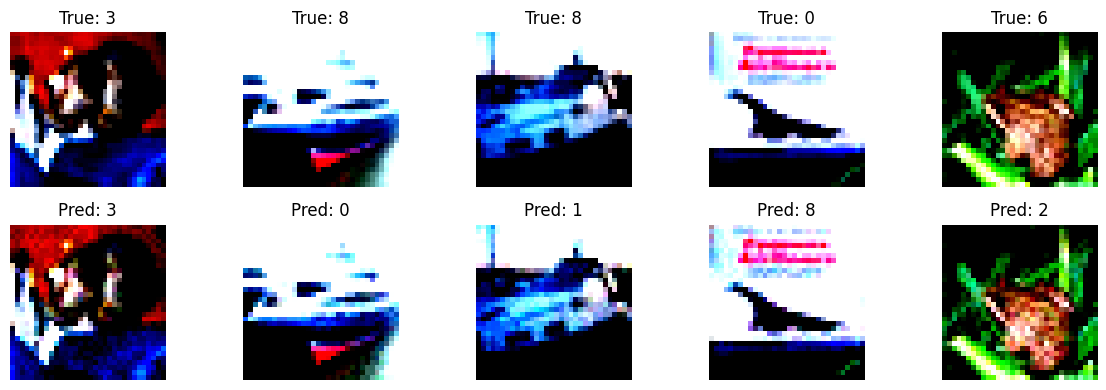

In [ ]:
n = 5
plt.figure(figsize=(12, 4))
for i in range(n):
    orig, adv, pred, true = examples[i]

    plt.subplot(2, n, i+1)
    plt.imshow(orig.permute(1, 2, 0))
    plt.title(f"True: {true.item()}")
    plt.axis('off')

    plt.subplot(2, n, i+1+n)
    plt.imshow(adv.permute(1, 2, 0))
    plt.title(f"Pred: {pred.item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Model accuracy before and after attack

In [30]:
for eps in [0, 0.01, 0.05, 0.1, 0.2, 0.3]:
    acc = evaluate_accuracy(model_base, val_loader, eps, device=device)
    print(f"Epsilon: {eps:.2f}, Accuracy on adversarial: {acc*100:.2f}%")

Epsilon: 0.00, Accuracy on adversarial: 85.18%
Epsilon: 0.01, Accuracy on adversarial: 49.71%
Epsilon: 0.05, Accuracy on adversarial: 10.07%
Epsilon: 0.10, Accuracy on adversarial: 4.64%
Epsilon: 0.20, Accuracy on adversarial: 3.89%
Epsilon: 0.30, Accuracy on adversarial: 4.36%


In [29]:
for eps in [0, 0.01, 0.05, 0.1, 0.2, 0.3]:
    acc = evaluate_accuracy(model_base, test_loader, eps, device=device)
    print(f"Epsilon: {eps:.2f}, Accuracy on adversarial: {acc*100:.2f}%")

Epsilon: 0.00, Accuracy on adversarial: 84.60%
Epsilon: 0.01, Accuracy on adversarial: 47.47%
Epsilon: 0.05, Accuracy on adversarial: 10.18%
Epsilon: 0.10, Accuracy on adversarial: 4.85%
Epsilon: 0.20, Accuracy on adversarial: 4.38%
Epsilon: 0.30, Accuracy on adversarial: 5.41%


## Exercise 2.2: Augment training with adversarial examples

### Functions

In [ ]:
def train_with_fgsm(model, train_loader, optimizer, criterion, epoch, epsilon, alpha=0.5, device='cuda'):
    model.train()
    total_losses = []

    for images, labels in tqdm(train_loader, desc=f'Training epoch {epoch}', leave=True):
        images, labels = images.to(device), labels.to(device)
        images.requires_grad = True

        outputs = model(images)
        loss = criterion(outputs, labels)

        model.zero_grad()
        loss.backward(retain_graph=True)

        grad_sign = images.grad.data.sign()
        adv_images = images + epsilon * grad_sign

        adv_outputs = model(adv_images.detach())
        adv_loss = criterion(adv_outputs, labels)

        total_loss = alpha * loss + (1-alpha) * adv_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        total_losses.append(total_loss.item())

    return np.mean(total_losses)

In [ ]:
def train(model, epochs, optimizer, train_loader, criterion, epsilon, alpha=0.5, device='cpu'):
  losses = []

  for epoch in range(epochs):

    loss = train_with_fgsm(model, train_loader, optimizer, criterion, epoch, epsilon, alpha, device=device)
    losses.append(loss)

  return losses

### Training

In [ ]:
epochs = 100
lr = 0.001
seed = 1023
torch.manual_seed(seed)

depth=5

model = Net(mode='cnn', in_channels=3, base_channels=64, depth=depth, residual=True, output_size=10).to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

losses = train(model, epochs, optimizer, train_loader, F.cross_entropy, epsilon=0.01, device=device)

Training epoch 99: 100%|██████████| 625/625 [00:54<00:00, 11.57it/s]


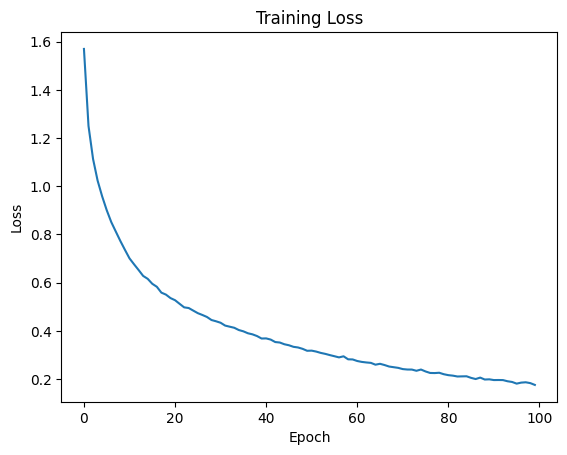

In [ ]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

### Base model accuracy before and after attack

In [ ]:
for eps in [0, 0.01, 0.05, 0.1, 0.2, 0.3]:
    acc = evaluate_accuracy(model_base, val_loader, eps, device=device)
    print(f"Epsilon: {eps:.2f}, Accuracy on adversarial: {acc*100:.2f}%")

Epsilon: 0.00, Accuracy on adversarial: 85.18%
Epsilon: 0.01, Accuracy on adversarial: 49.71%
Epsilon: 0.05, Accuracy on adversarial: 10.07%
Epsilon: 0.10, Accuracy on adversarial: 4.64%
Epsilon: 0.20, Accuracy on adversarial: 3.89%
Epsilon: 0.30, Accuracy on adversarial: 4.36%


In [ ]:
for eps in [0, 0.01, 0.05, 0.1, 0.2, 0.3]:
    acc = evaluate_accuracy(model_base, test_loader, eps, device=device)
    print(f"Epsilon: {eps:.2f}, Accuracy on adversarial: {acc*100:.2f}%")

Epsilon: 0.00, Accuracy on adversarial: 84.60%
Epsilon: 0.01, Accuracy on adversarial: 47.47%
Epsilon: 0.05, Accuracy on adversarial: 10.18%
Epsilon: 0.10, Accuracy on adversarial: 4.85%
Epsilon: 0.20, Accuracy on adversarial: 4.38%
Epsilon: 0.30, Accuracy on adversarial: 5.41%


### Augmented model accuracy before and after attack

In [ ]:
for eps in [0, 0.01, 0.05, 0.1, 0.2, 0.3]:
    acc = evaluate_accuracy(model, val_loader, eps)
    print(f"Epsilon: {eps:.2f}, Accuracy on adversarial: {acc*100:.2f}%")

Epsilon: 0.00, Accuracy on adversarial: 86.97%
Epsilon: 0.01, Accuracy on adversarial: 77.49%
Epsilon: 0.05, Accuracy on adversarial: 32.65%
Epsilon: 0.10, Accuracy on adversarial: 8.61%
Epsilon: 0.20, Accuracy on adversarial: 2.41%
Epsilon: 0.30, Accuracy on adversarial: 1.65%


In [ ]:
for eps in [0, 0.01, 0.05, 0.1, 0.2, 0.3]:
    acc = evaluate_accuracy(model, test_loader, eps)
    print(f"Epsilon: {eps:.2f}, Accuracy on adversarial: {acc*100:.2f}%")

Epsilon: 0.00, Accuracy on adversarial: 86.81%
Epsilon: 0.01, Accuracy on adversarial: 76.38%
Epsilon: 0.05, Accuracy on adversarial: 30.00%
Epsilon: 0.10, Accuracy on adversarial: 9.39%
Epsilon: 0.20, Accuracy on adversarial: 3.26%
Epsilon: 0.30, Accuracy on adversarial: 2.08%


### Logits and probabilities

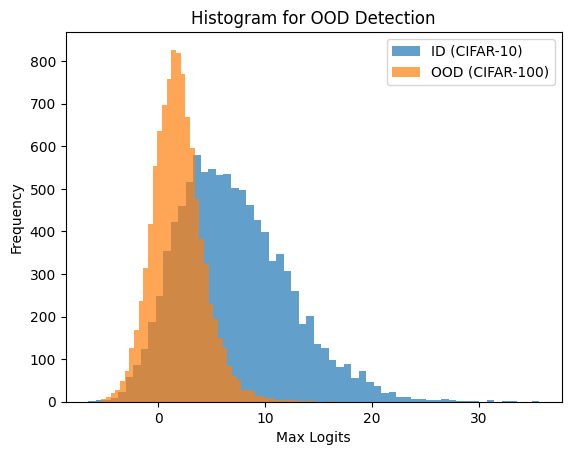

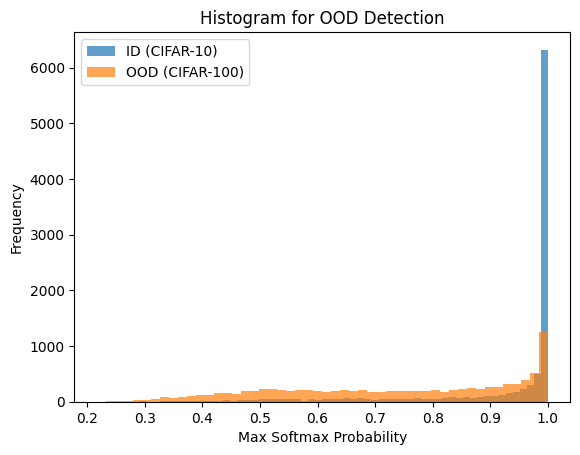

In [ ]:
id_logits, id_probs = get_scores(test_loader, model)
ood_logits, ood_probs = get_scores(ood_loader, model)

plot_histograms(id_logits, id_probs, ood_logits, ood_probs)

### ROC and Precision-Recall curves

ROC AUC = 0.8327


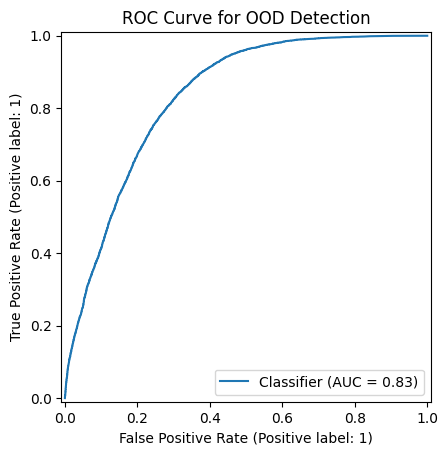

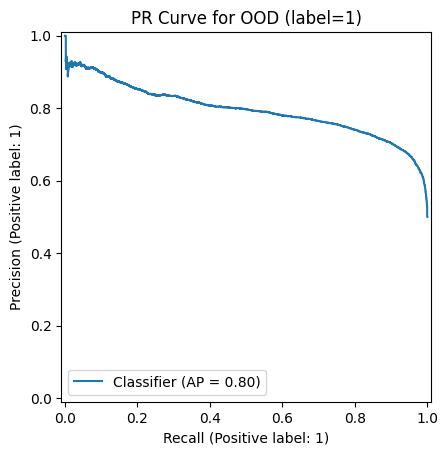

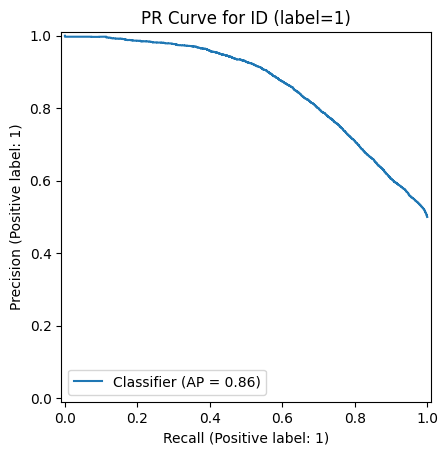

In [ ]:
id_logits, id_probs = get_scores(test_loader, model)
ood_logits, ood_probs = get_scores(ood_loader, model)

labels = np.array([0] * len(id_probs) + [1] * len(ood_probs))

scores = np.array(id_probs + ood_probs)

plot_roc_pr_curves(labels, scores)

## Exercise 3: Implement ODIN for OOD detection

In [39]:
def get_odin_scores(model, dataloader, device, temperature=1.0, epsilon=0.001):
    model.eval()
    logits_scores =[]
    softmax_scores = []

    for images, _ in tqdm(dataloader, desc="ODIN Scoring"):
        images = images.to(device)
        images.requires_grad = True

        outputs = model(images) / temperature
        preds = outputs.max(1)[1]

        loss = F.cross_entropy(outputs, preds)
        model.zero_grad()
        loss.backward()

        grad_sign = images.grad.data.sign()
        perturbed_images = images - epsilon * grad_sign

        with torch.no_grad():

          logits = model(images)
          max_logit, _ = torch.max(logits, dim=1)

          odin_outputs = model(perturbed_images) / temperature
          probs = F.softmax(odin_outputs, dim=1)
          max_probs = probs.max(1)[0]

        logits_scores.extend(max_logit.cpu().numpy())
        softmax_scores.extend(max_probs.cpu().numpy())

    return np.array(logits_scores), np.array(softmax_scores)

In [23]:
temps = [1.0, 10.0, 50.0, 100.0]
epsilons = [0.0, 0.001, 0.002, 0.004]

best_auc = 0
best_params = None

for T in temps:
    for eps in epsilons:
        id_scores = get_odin_scores(model_base, test_loader, device, T, eps)
        ood_scores = get_odin_scores(model_base, ood_loader, device, T, eps)

        labels = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
        scores = np.concatenate([id_scores, ood_scores])

        auc = roc_auc_score(labels, scores)
        print(f"T={T}, eps={eps}, ROC AUC={auc:.4f}")

        if auc > best_auc:
            best_auc = auc
            best_params = (T, eps)

ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 16.97it/s]


T=1.0, eps=0.0, ROC AUC=0.8090


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.01it/s]


T=1.0, eps=0.001, ROC AUC=0.8108


ODIN Scoring: 100%|██████████| 157/157 [00:10<00:00, 15.28it/s]


T=1.0, eps=0.002, ROC AUC=0.8115


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 16.89it/s]


T=1.0, eps=0.004, ROC AUC=0.8105


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.16it/s]


T=10.0, eps=0.0, ROC AUC=0.8609


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.14it/s]


T=10.0, eps=0.001, ROC AUC=0.8592


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.32it/s]


T=10.0, eps=0.002, ROC AUC=0.8571


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 15.93it/s]


T=10.0, eps=0.004, ROC AUC=0.8524


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.38it/s]


T=50.0, eps=0.0, ROC AUC=0.8624


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.20it/s]


T=50.0, eps=0.001, ROC AUC=0.8604


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.39it/s]


T=50.0, eps=0.002, ROC AUC=0.8582


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.06it/s]


T=50.0, eps=0.004, ROC AUC=0.8533


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.39it/s]


T=100.0, eps=0.0, ROC AUC=0.8621


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 16.93it/s]


T=100.0, eps=0.001, ROC AUC=0.8600


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 17.29it/s]


T=100.0, eps=0.002, ROC AUC=0.8578


ODIN Scoring: 100%|██████████| 157/157 [00:09<00:00, 16.92it/s]

T=100.0, eps=0.004, ROC AUC=0.8529


In [50]:
T, eps = best_params
print(f"Best parameters: T={T}, eps={eps}")

id_logits, id_probs = get_odin_scores(model_base, test_loader, device, T, eps)
ood_logits, ood_probs = get_odin_scores(model_base, ood_loader, device, T, eps)

labels = np.concatenate([np.ones_like(id_probs), np.zeros_like(ood_probs)])
scores = np.concatenate([id_probs, ood_probs])

auc = roc_auc_score(labels, scores)

Best parameters: T=50.0, eps=0.0


ODIN Scoring: 100%|██████████| 157/157 [00:10<00:00, 14.38it/s]


ROC AUC = 0.8624


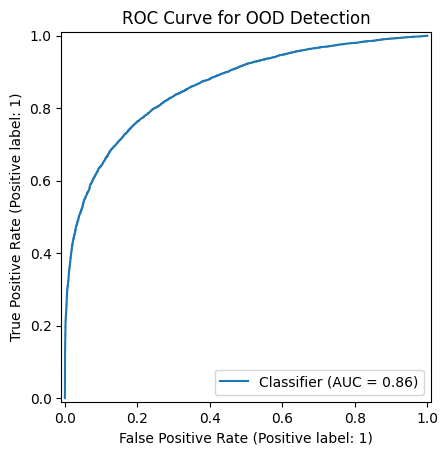

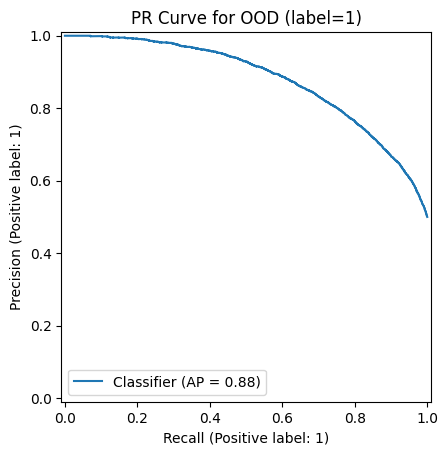

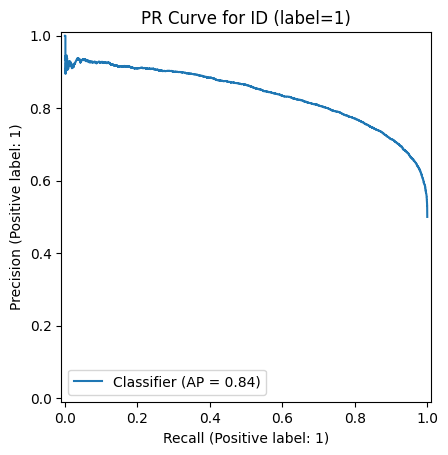

In [51]:
plot_roc_pr_curves(labels, -scores)

In [47]:
def plot_histograms(id_logits, id_probs, ood_logits, ood_probs):
  plt.hist(id_logits, bins=80, alpha=0.7, label='ID (CIFAR-10)')
  plt.hist(ood_logits, bins=50, alpha=0.7, label='OOD (CIFAR-100)')
  plt.xlabel('Max Logits')
  plt.ylabel('Frequency')
  plt.title('Histogram for OOD Detection')
  plt.legend()
  plt.show()

  plt.hist(id_probs, bins=90, alpha=0.7, label='ID (CIFAR-10)')
  plt.hist(ood_probs, bins=50, alpha=0.7, label='OOD (CIFAR-100)')
  plt.xlabel('Max Softmax Probability')
  plt.ylabel('Frequency')
  plt.title('Histogram for OOD Detection')
  plt.legend()
  plt.show()

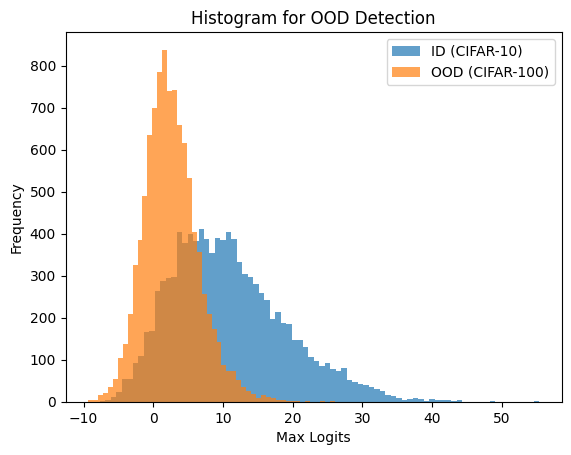

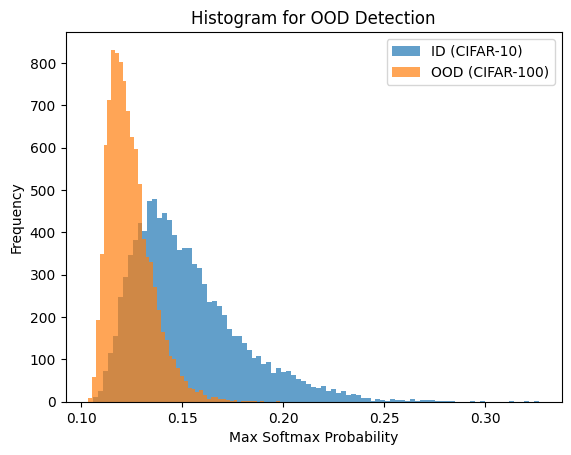

In [48]:
plot_histograms(id_logits, id_probs, ood_logits, ood_probs)